In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, matthews_corrcoef, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns

O:\anaconda3\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
### Preparing DATA
# Load dataset into a pandas dataframe
df = pd.read_csv('final.txt')

# prepare the modified Data
df2= pd.DataFrame()
df2['pair']=df['pair']
df2['pdb_id'] = df2['pair'].apply(lambda x: x.split('_')[0])
df2['chain1'] = df2['pair'].apply(lambda x: x.split('_')[1])
df2['chain2'] = df2['pair'].apply(lambda x: x.split('_')[3])

# Make it binary by setting a threshold and split training and test
df2['binary_obs_contact'] = np.where(df['obs_contact'] > 15, 1, 0)  # change here if necessary

selected_features = ['IntraclashesGroup1', 'IntraclashesGroup2', 'Interaction Energy',
       'Backbone Hbond', 'Sidechain Hbond', 'Van der Waals', 'Electrostatics',
       'Solvation Polar', 'Solvation Hydrophobic', 'Van der Waals clashes',
       'entropy sidechain', 'entropy mainchain', 'ptm_iptm',
       'pdockq2', 'pdockq1', 'Number of Residues', 'backbone clash',
       'Interface Residues', 'pred_contact', 'Interface Residues Clashing', 'electrostatic kon',
       'Interface Residues BB Clashing', 'Interface Residues VdW Clashing']
df2[selected_features]=df[selected_features]

In [4]:
def get_tp_tn_fp_fn(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp, tn, fp, fn
def safe_mcc(y_true, y_pred):
    eps = np.finfo(np.float64).eps # smallest representable positive number
    tp, tn, fp, fn = get_tp_tn_fp_fn(y_true, y_pred) # function to calculate tp, tn, fp, fn
    denom = np.sqrt((tp + fp + eps) * (tp + fn + eps) * (tn + fp + eps) * (tn + fn + eps))
    return (tp * tn - fp * fn) / denom

In [4]:
ranked_df=pd.DataFrame()

# Make it binary by setting a threshold and split training and test
ranked_df['binary_obs_contact'] = df2['binary_obs_contact']

# Generate a random feature
ranked_df['random1'] = np.random.randint(low=1, high=1370, size=1370)
ranked_df['random2'] = np.random.randint(low=1, high=1370, size=1370)
ranked_df['random3'] = np.random.randint(low=1, high=1370, size=1370)
ranked_df['random4'] = np.random.randint(low=1, high=1370, size=1370)
ranked_df['random5'] = np.random.randint(low=1, high=1370, size=1370)
ranked_df['random6'] = np.random.randint(low=1, high=1370, size=1370)
ranked_df['random7'] = np.random.randint(low=1, high=1370, size=1370)

features_dic = {}
thresholds_dic = {}
for feature in selected_features+['random1','random2','random3','random4','random5','random6','random7']:
    
    if feature[:6] != 'random':
        ranked_df[feature] = df2[feature].rank()
    
    # Check the correlation
    if np.corrcoef(ranked_df['binary_obs_contact'],ranked_df[feature])[0][1] > 0:
        # Compute F1 score for different threshold values
        thresholds = [i for i in range(1, 1370)]
        f1_scores = []
        for t in thresholds:
            y_pred_binary = (ranked_df[feature] >= t).astype(int)
            MCC = safe_mcc(ranked_df['binary_obs_contact'], y_pred_binary)
            f1_scores.append(MCC)
        # Find the threshold that maximizes F1 score
        best_threshold = thresholds[f1_scores.index(max(f1_scores))]
        y_pred_binary = (ranked_df[feature] >= best_threshold).astype(int)
        print (feature)
        print ('MCC: ',safe_mcc(ranked_df['binary_obs_contact'], y_pred_binary))
        print (confusion_matrix(ranked_df['binary_obs_contact'], y_pred_binary))
        print (classification_report(ranked_df['binary_obs_contact'], y_pred_binary))
        #print("Best threshold:", best_threshold)
        #print("Best macro f1:", max(f1_scores))
        print ('\n')
        thresholds_dic[feature]=[best_threshold,1]
    
    else:
        # Compute F1 score for different threshold values
        thresholds = [i for i in range(1, 1370)]
        f1_scores = []
        for t in thresholds:
            y_pred_binary = (ranked_df[feature] <= t).astype(int)
            MCC = safe_mcc(ranked_df['binary_obs_contact'], y_pred_binary)
            f1_scores.append(MCC)
        # Find the threshold that maximizes F1 score
        best_threshold = thresholds[f1_scores.index(max(f1_scores))]
        y_pred_binary = (ranked_df[feature] <= best_threshold).astype(int)
        print (feature)
        print ('MCC: ',safe_mcc(ranked_df['binary_obs_contact'], y_pred_binary))
        print (confusion_matrix(ranked_df['binary_obs_contact'], y_pred_binary))
        print (classification_report(ranked_df['binary_obs_contact'], y_pred_binary))
        #print("Best threshold:", best_threshold)
        #print("Best macro f1 score:", max(f1_scores))
        print ('\n')
        thresholds_dic[feature]=[best_threshold,-1]
    features_dic[feature]=safe_mcc(ranked_df['binary_obs_contact'], y_pred_binary)

features_dic['random']=np.mean([features_dic['random1'],features_dic['random2'],features_dic['random3'],features_dic['random4'],features_dic['random5'],features_dic['random6'],features_dic['random7']])
del features_dic['random1']; del features_dic['random2']; del features_dic['random3']; del features_dic['random4']; del features_dic['random5']; del features_dic['random6']; del features_dic['random7']

IntraclashesGroup1
MCC:  0.11439842780746069
[[ 17 601]
 [  1 751]]
              precision    recall  f1-score   support

           0       0.94      0.03      0.05       618
           1       0.56      1.00      0.71       752

    accuracy                           0.56      1370
   macro avg       0.75      0.51      0.38      1370
weighted avg       0.73      0.56      0.42      1370



IntraclashesGroup2
MCC:  0.15657738824149328
[[184 434]
 [125 627]]
              precision    recall  f1-score   support

           0       0.60      0.30      0.40       618
           1       0.59      0.83      0.69       752

    accuracy                           0.59      1370
   macro avg       0.59      0.57      0.54      1370
weighted avg       0.59      0.59      0.56      1370



Interaction Energy
MCC:  0.2388380819296947
[[200 418]
 [ 95 657]]
              precision    recall  f1-score   support

           0       0.68      0.32      0.44       618
           1       0.61      0

Interface Residues BB Clashing
MCC:  0.1608894359080364
[[ 80 538]
 [ 31 721]]
              precision    recall  f1-score   support

           0       0.72      0.13      0.22       618
           1       0.57      0.96      0.72       752

    accuracy                           0.58      1370
   macro avg       0.65      0.54      0.47      1370
weighted avg       0.64      0.58      0.49      1370



Interface Residues VdW Clashing
MCC:  0.20184659989501577
[[228 390]
 [142 610]]
              precision    recall  f1-score   support

           0       0.62      0.37      0.46       618
           1       0.61      0.81      0.70       752

    accuracy                           0.61      1370
   macro avg       0.61      0.59      0.58      1370
weighted avg       0.61      0.61      0.59      1370



random1
MCC:  0.032284416204935655
[[ 34 584]
 [ 31 721]]
              precision    recall  f1-score   support

           0       0.52      0.06      0.10       618
           1   

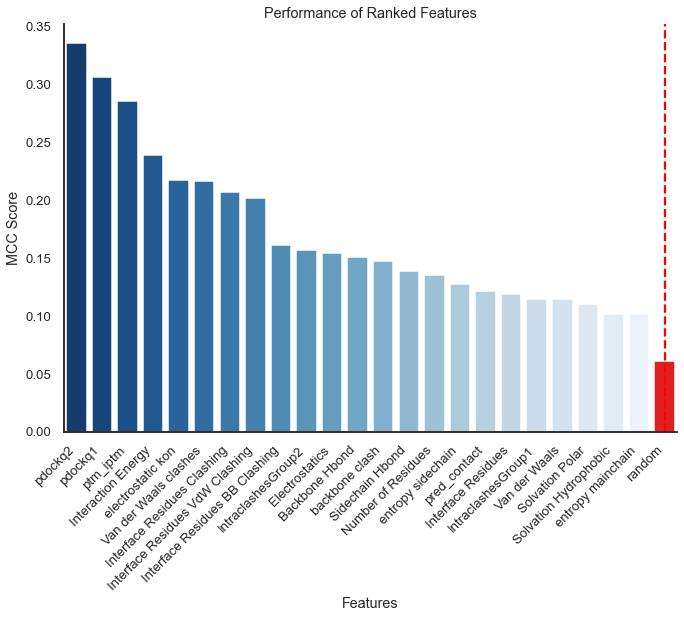

In [5]:
#random=np.mean([features_dic['random1'],features_dic['random2'],features_dic['random3']])
#del features_dic['random1']; del features_dic['random2']; del features_dic['random3'];

# Convert the dictionary into a Pandas DataFrame and sort by value in descending order
df_tmp = pd.DataFrame(list(features_dic.items()), columns=["Features", "Values"]).sort_values(by="Values", ascending=False)

# Set the x-axis label and rotate the labels for better visibility
sns.set(rc={'figure.figsize':(11,7.5)})
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

# Set the color palette with red for "random" feature and blues_r for others
palette = {"random": "red"}
other_palette = sns.color_palette("Blues_r", len(df_tmp))
for i, feature in enumerate(df_tmp["Features"].tolist()):
    if feature != "random":
        palette[feature] = other_palette[i]

# Create the bar plot
ax = sns.barplot(x="Features", y="Values", data=df_tmp, order=df_tmp["Features"], palette=palette)
sns.despine()
plt.xticks(rotation=45, ha='right')
plt.ylabel("MCC Score")
plt.title('Performance of Ranked Features')

# Add a vertical dashed red line at the location of the "random" bar
random_index = np.where(df_tmp["Features"]=="random")[0][0]
ax.axvline(x=random_index, color="red", linestyle="--")

plt.show()

In [6]:
ranked_df = ranked_df.drop(['random1', 'random2', 'random3', 'random4', 'random5', 'random6', 'random7'],axis=1)
#ranked_df

In [7]:
X = ranked_df.drop(['binary_obs_contact'], axis=1)
y = ranked_df['binary_obs_contact']
# Split dataset into training and testing sets based on each structure complex
train_ids, test_ids = train_test_split(df2['pdb_id'].unique(), test_size=0.2, random_state=112)
X_train = ranked_df[df2.pdb_id.isin(train_ids)].drop(['binary_obs_contact'], axis=1) # features
X_test = ranked_df[df2.pdb_id.isin(test_ids)].drop(['binary_obs_contact'], axis=1) # features
y_train = df2[df2.pdb_id.isin(train_ids)]['binary_obs_contact'] # Target variable
y_test = ranked_df[df2.pdb_id.isin(test_ids)]['binary_obs_contact'] # Target variable
# scale numerical features
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

Best n_estimators parameter:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
[[45 14]
 [46 99]]
MCC score:  0.40632077102757663
              precision    recall  f1-score   support

           0       0.49      0.76      0.60        59
           1       0.88      0.68      0.77       145

    accuracy                           0.71       204
   macro avg       0.69      0.72      0.68       204
weighted avg       0.77      0.71      0.72       204



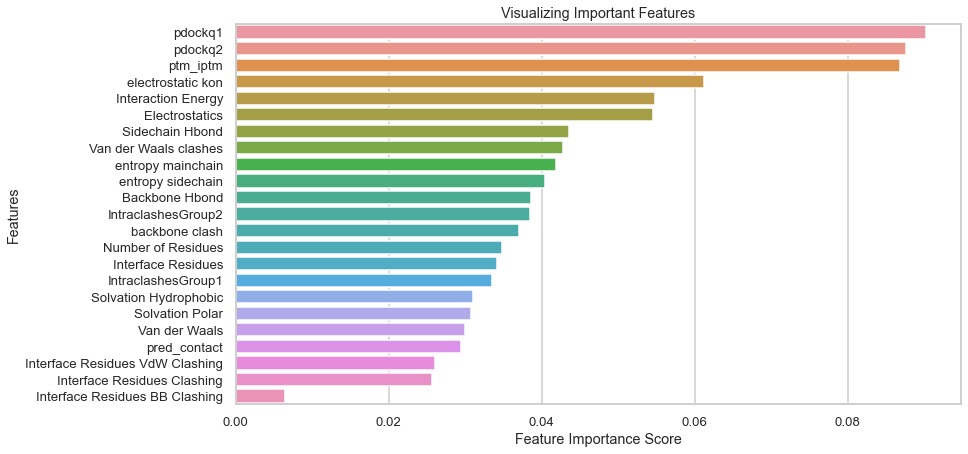

In [8]:
# Create a random forest model
rfc = RandomForestClassifier()

# Define parameter grid for grid search
#param_grid = {'n_estimators': [200],'random_state':[1,42,100]}
#param_grid = {'n_estimators': [100, 200],'max_depth': [5, 10, 20, None],'min_samples_split': [2, 5, 10],'max_features': ['auto', 'sqrt']}
param_grid = {'n_estimators': [100],'max_depth': [20],'min_samples_split': [10],'max_features': ['sqrt']}
# Perform grid search with 4 cross folds
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring='f1')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
# Print the best parameter and best score
#print("Best n_estimators parameter: ", best_params['n_estimators'])
print("Best n_estimators parameter: ", best_params)
#print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# fit a new model using the best hyperparameters
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(X_train, y_train)
# Make prediction
y_pred = rf_best.predict(X_test)
# Report the performance evaluation
#print('Accuracy:', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print ('MCC score: ',matthews_corrcoef(y_test, y_pred))
print(classification_report(y_test, y_pred))



feature_importances = rf_best.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]
# Get names of features and their importance scores
feature_names = X.columns
feature_importances = feature_importances[indices]
# Plot feature importances
sns.set_style("whitegrid")
plt.figure(figsize=(13, 7))
sns.barplot(x=feature_importances, y=feature_names[indices])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()